In [44]:
import os
import imageio
import datetime

import gym
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

from collections import deque

In [45]:
class NN:
    def __init__(self,N_ACT,N_OB,LEARNING_RATE = 0.01):
        self.learning_rate = LEARNING_RATE
        self.input_shape   = N_OB
        self.output_shape   = N_ACT
        
        self.model = self.create_nn()
        
    def create_nn(self):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(32,activation = 'relu',input_shape=self.input_shape),
            tf.keras.layers.Dense(32,activation = 'relu'),
            tf.keras.layers.Dense(self.output_shape, activation = 'linear')
        ])
        model.compile(
            loss = 'mse',
            optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
            metrics = ['accuracy']
        )
        return model

In [46]:
class Replay:
    def __init__(self, MEMORY_SIZE = 5000, BATCH_SIZE = 64):
        self.BATCH_SIZE = BATCH_SIZE
        self.MEMORY_SIZE = MEMORY_SIZE
        self.memory = deque([],maxlen = MEMORY_SIZE)
        
    def memo_append(self, a_set_memory):
        # a_set_memory = sars(a) : [ob, (act), reward, ob_next, done]
        self.memory.append(a_set_memory)

    def memo_len(self):
        return len(self.memory)
        
    def sample(self):
        return random.sample(self.memory,self.BATCH_SIZE)

In [47]:
class Agent(Replay,NN):
    def __init__(self, N_ACT,N_OB,                \
                    GAMMA   = 0.9,                \
                    EPSILON = 0.3,                \
                    MODEL_UPDATE_STEP   = 200,    \
                    MEMORY_SAMPLE_START = 20,     \
                    LEARNING_RATE = 0.01,         \
                    MEMORY_SIZE  = 10_000,        \
                    BATCH_SIZE   = 64):
        
        Replay.__init__(self, MEMORY_SIZE = MEMORY_SIZE, \
                        BATCH_SIZE = BATCH_SIZE)
        NN.__init__(self, N_ACT, N_OB, \
                     LEARNING_RATE = LEARNING_RATE)
        self.N_ACT = N_ACT
        self.GAMMA   = GAMMA
        self.EPSILON = EPSILON

        self.target_model = self.create_nn()
        self.target_model.set_weights(self.model.get_weights())
        
        self.MODEL_UPDATE_STEP = MODEL_UPDATE_STEP
        self.STEP = 0
        
        self.MEMORY_SAMPLE_START = MEMORY_SAMPLE_START
        
    def get_q_value(self, state):
        # mountain car state = ob
        return self.model.predict(state)
    
    def get_action(self,state): 
        # get action with epsilon greedy
        q = self.get_q_value(state)
        if np.random.rand() < self.EPSILON:            
            return np.random.randint(self.N_ACT), np.amax(q)
        return np.argmax(q), np.amax(q)
    
    def train(self): 
        #if the momery len < its thershold
        if self.memo_len() < self.MEMORY_SAMPLE_START:
            return
        
        batch_memo = self.sample()
        
        # model for q now
        batch_state = np.array([ a_set_memo[0][0,:,:,:] for a_set_memo in batch_memo])
        batch_q     = self.model.predict(batch_state)
        
        # target_model for max q
        batch_state_next = np.array([ a_set_memo[3][0,:,:,:] for a_set_memo in batch_memo])
        batch_q_next = self.target_model.predict(batch_state_next)
        
        batch_q_new = []
        
        for index,(state, action, reward, state_next, done) in enumerate(batch_memo):
            if done:
                q_new = reward
            else:
                q_new = reward + self.GAMMA * max(batch_q_next[index])
            
            q = batch_q[index]
            q[action] = q_new
            # TODO: maybe add a q offset bound in [-1,1]
            batch_q_new.append(q)
            
        self.STEP +=1
        history = self.model.fit(batch_state,np.array(batch_q_new),batch_size = self.BATCH_SIZE, verbose = 0)
        return history.history
    
    def target_model_update(self):
        if self.STEP < self.MODEL_UPDATE_STEP:
            return
        self.STEP = 0
        self.target_model.set_weights(self.model.get_weights())

In [48]:
class Args:
    EPOCHS   = 500
    EPOCHS_T = 250
    #FRAME_END   = 500
    GAMMA    = 0.99

    EPSILON  = 1.0
    EPSILON_END    = 0.01

    
    LEARNING_RATE = 0.001
    
    BATCH_SIZE  = 32
    
    MEMORY_SIZE = 10000
    MEMORY_SAMPLE_START = 500
    
    MODEL_UPDATE_STEP   = 300

In [49]:
args = Args
EPOCHS = args.EPOCHS
EPOCHS_T  = args.EPOCHS_T

GAMMA   = args.GAMMA
EPSILON = args.EPSILON
EPSILON_END   = args.EPSILON_END

LEARNING_RATE = args.LEARNING_RATE

BATCH_SIZE = args.BATCH_SIZE
MEMORY_SIZE = args.MEMORY_SIZE
MEMORY_SAMPLE_START = args.MEMORY_SAMPLE_START

MODEL_UPDATE_STEP = args.MODEL_UPDATE_STEP

In [50]:
env = gym.make('MountainCar-v0')
ob = env.reset()

N_ACT = env.action_space.n
N_OB  = env.observation_space.shape
#print(env.action_space.n)
#print(env.observation_space.shape)

In [51]:
agent = Agent(N_ACT,N_OB, \
              GAMMA = GAMMA, EPSILON = EPSILON, \
              MODEL_UPDATE_STEP   = MODEL_UPDATE_STEP, \
              MEMORY_SAMPLE_START = MEMORY_SAMPLE_START, \
              LEARNING_RATE = LEARNING_RATE, \
              MEMORY_SIZE   = MEMORY_SIZE, \
              BATCH_SIZE    = BATCH_SIZE)

In [52]:
agent.model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 99        
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


In [53]:
ROOT_DIR = 'test_gif'
DIR = os.path.join(ROOT_DIR,datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
DIR_GIF = os.path.join(DIR,'gif')
try:
    os.makedirs(DIR)
    os.makedirs(DIR_GIF)
except:
    pass

In [54]:
log_file = open(DIR+'/log.txt','a')
log_file.write("EPOCH_END:{} \t FRAME_T:{}\n".format(EPOCHS,EPOCHS_T))
log_file.write("GAMMA:{} \t EPSILON:{} \t EPSILON_END:{} \t LEARNING_RATE:{}\n".format(GAMMA,EPSILON,EPSILON_END,LEARNING_RATE))
log_file.write("MEMORY_SIZE:{} \t MEMORY_SAMPLE_START:{}\n".format(MEMORY_SIZE,MEMORY_SAMPLE_START))
log_file.write("MODEL_UPDATE_STEP:{} \t BATCH_SIZE:{}\n".format(MODEL_UPDATE_STEP,BATCH_SIZE))
log_file.close()

In [36]:
reward_summary = []
history_summary = {
    'loss':[],
    'accuracy':[]
}

max_q_summary = []

epsilon_decay = (EPSILON-EPSILON_END)/EPOCHS_T

In [55]:
for ep in range(EPOCHS):
    loss        = []
    accuracy    = []
    reward_list = []
    max_q_list  = []
    images      = []
    ob = env.reset()
    
    step = 0
    while(1):
        if agent.EPSILON > EPSILON_END:
            agent.EPSILON -= epsilon_decay
        else:
            agent.EPSILON = EPSILON_END
        
        images.append(env.render(mode='rgb_array'))
        
        act,max_q = agent.get_action(ob)
        ob_next, reward, done, info = env.step(act)
        
        agent.memo_append([obb, act, reward, ob_next, done])
        
        history = agent.train()
        agent.target_model_update()
        
        if history:
            loss.append(history['loss'][0])
            accuracy.append(history['accuracy'][0])

        max_q_list.append(max_q)
        reward_list.append(max_q)
        ob = ob_next
        step +=1
        if done:
            break
    
    reward_summary.append(np.amax(reward_list))
    max_q_summary.append(np.amax(max_q_list))
    
    out = "\nEpoch {} \tepsilon: {:0.5f} \tsum_rewards: {} \tmax_q:{:e} \t".format(ep,agent.EPSILON,reward_summary[-1],max_q_summary[-1])
    log_file.write(out)
    print(out,end=" ")
    
    if len(loss):
        history_summary['loss'].append(sum(loss)/len(loss))
        history_summary['accuracy'].append(sum(accuracy)/len(accuracy))
        out = "ave loss: {:e} \tave accuracy: {:e}\t".format(history_summary['loss'][-1],history_summary['accuracy'][-1])
        log_file.write(out)
        print(out,end=" ")
    log_file.close()
    imageio.mimsave(os.path.join(DIR_GIF,str(ep)+'_step_'+str(step)+'_r_'+reward_summary[-1]+'.gif'),images,fps=60)
    
    
    
    

ValueError: in user code:

    /Users/vac/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /Users/vac/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/vac/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/vac/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/vac/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/vac/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1445 run_step  **
        outputs = model.predict_step(data)
    /Users/vac/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1418 predict_step
        return self(x, training=False)
    /Users/vac/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /Users/vac/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer sequential_4 is incompatible with the layer: expected axis -1 of input shape to have value 2 but received input with shape [None, 1]


In [56]:
print(ob.shape)

(2,)


Show the reward every ep


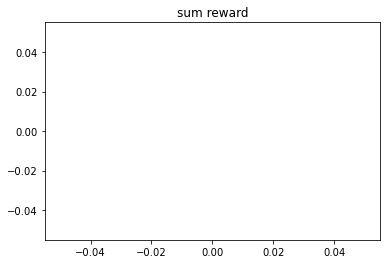

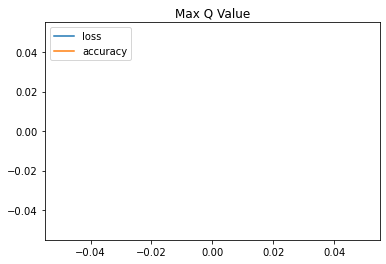

In [43]:
print('Show the reward every ep')
plt.figure()
plt.plot(reward_summary)
plt.title('sum reward')
plt.savefig(DIR + '/rewards_sum.png')
plt.figure()
plt.plot(history_summary['loss'],label='loss')
plt.plot(history_summary['accuracy'],label='accuracy')
plt.legend(loc=2)
plt.savefig(DIR + '/loss_accuracy.png')
plt.figure()
plt.plot(max_q_summary)
plt.title("Max Q Value")
plt.savefig(DIR + '/max_q.png')

In [ ]:
ob = env.reset()
images = []
reward_list =[]
step = 0
while(1):
    images.append(env.render(mode='rgb_array'))
    act = np.argmax(agent.get_q_value(ob))

    ob_next,reward,done,info = env.step(act)
   
    reward_list.append(reward)
    step +=1
    ob = ob_next
    
    if done :
        break
imageio.mimsave(os.path.join(DIR,s'final_step_'+str(step)+'_r_'+np.amax(reward_list)+'.gif'),images,fps=60)



In [11]:
DIR_GIF = "test_gif"
try:
    os.mkdir(DIR_GIF)
except:
    pass

In [14]:
images=[]
for _ in range(40):
    images.append(env.render(mode='rgb_array'))
    act = env.action_space.sample()
    print(act)
    ob_next, reward, done, info  = env.step(act)
    if done:
        break
imageio.mimsave(os.path.join(DIR_GIF,'test.gif'),images,fps=60)

1
1
2
2
1
2
2
1
1
1
2
1
2
2
2
1
0
0
2
0
1
2
2
1
1
1
1
1
0
2
0
0
0
2
1
0
2
0
2
2


In [13]:
imageio.mimsave(os.path.join(DIR_GIF,'test.gif'),images,fps=60)